In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
df_clean = pd.read_csv("dataset\df_clean.csv")
print(df_clean.columns) 
print(df_clean.shape)


Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='str')
(2850, 14)


In [14]:
churn_dist = df_clean["Churn"].value_counts(normalize=True)
print("Churn Distribution: ", churn_dist)

Churn Distribution:  Churn
0    0.843509
1    0.156491
Name: proportion, dtype: float64


Model might  bias against churning because it only owns 15.7% of the data

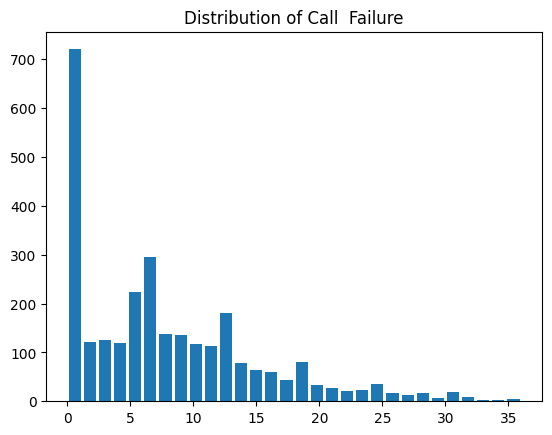

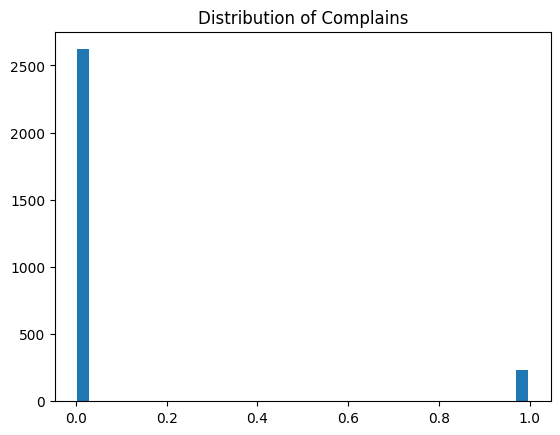

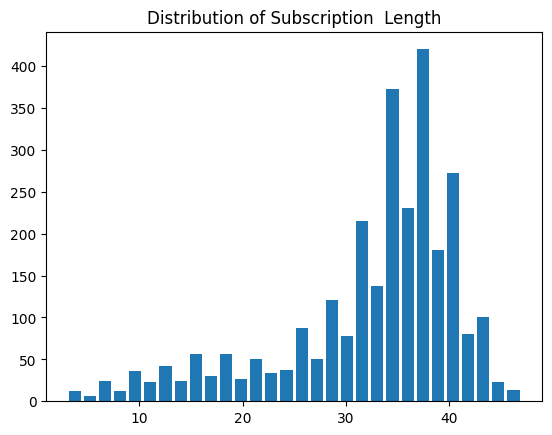

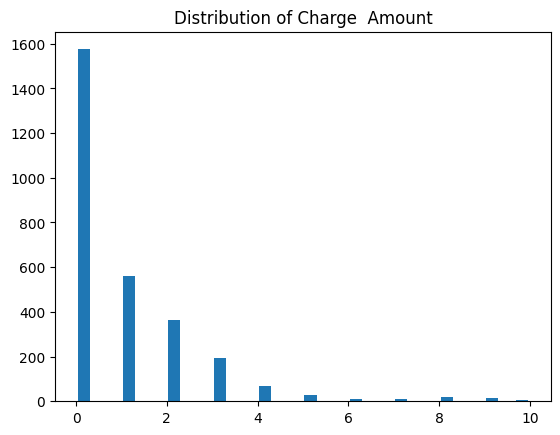

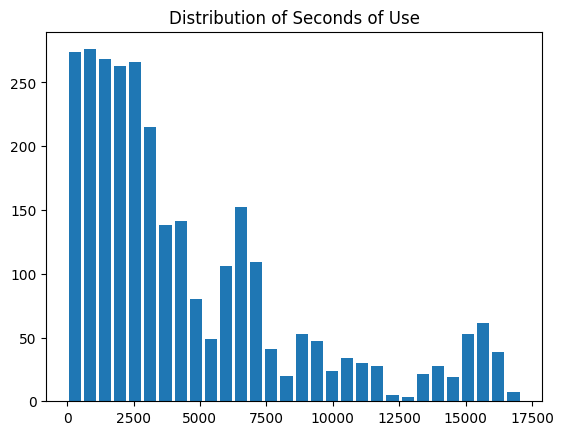

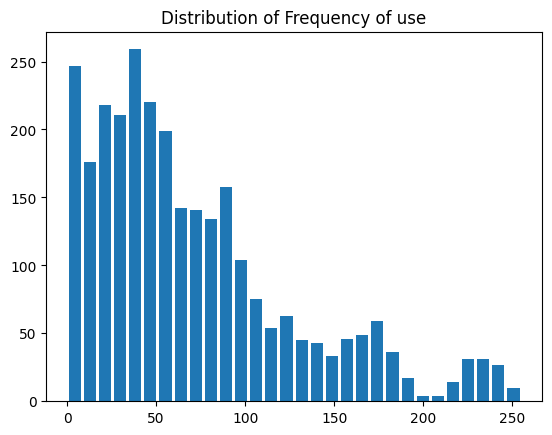

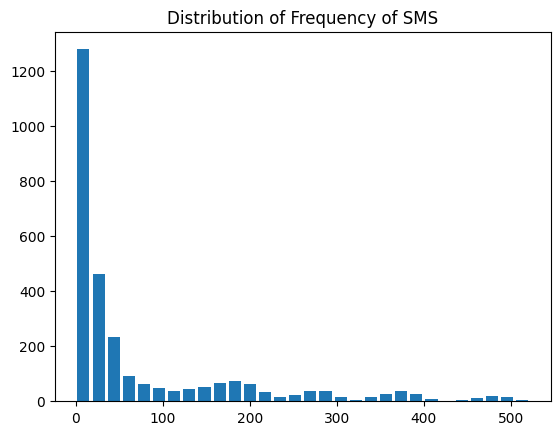

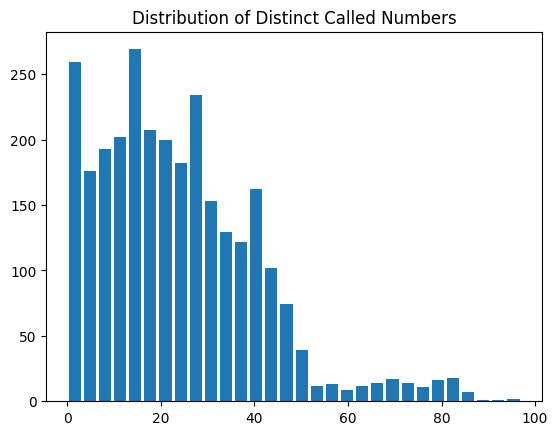

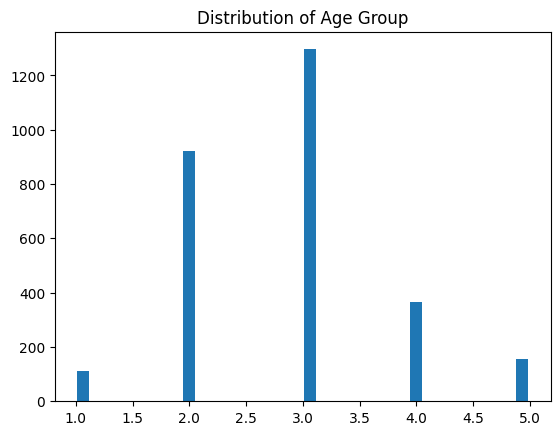

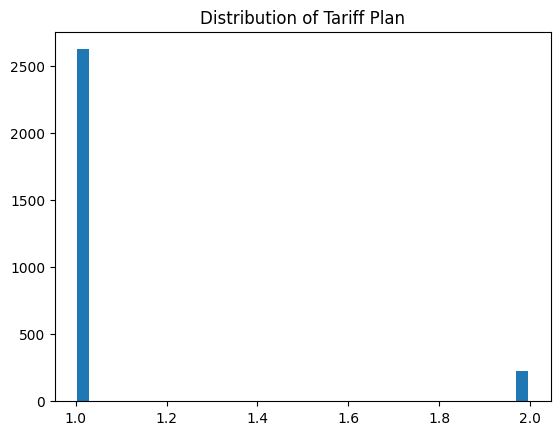

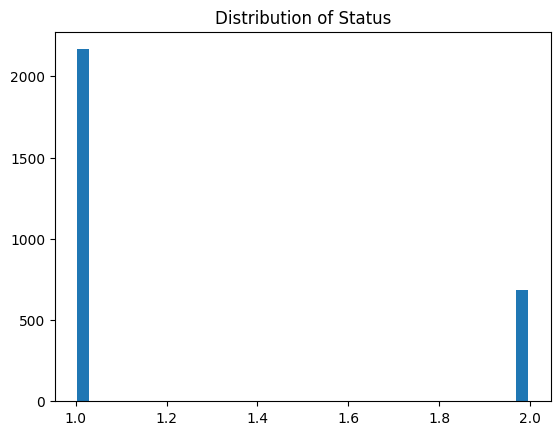

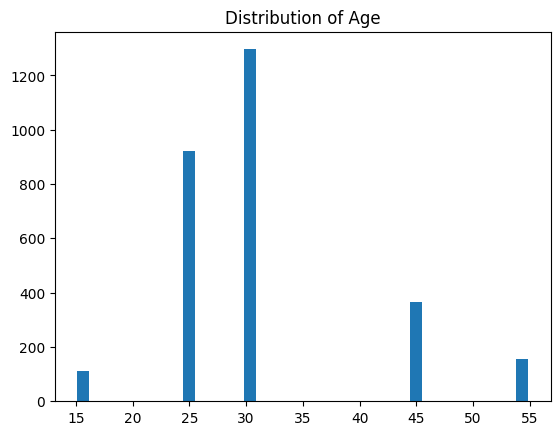

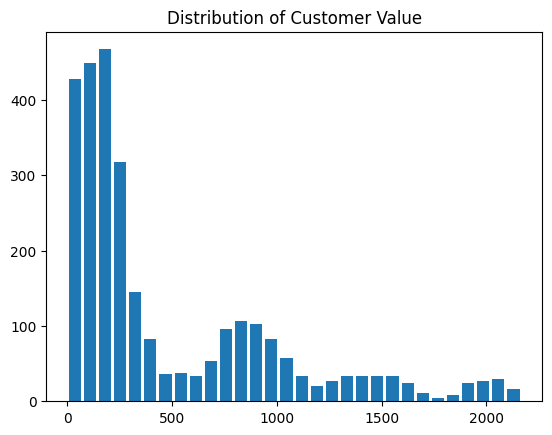

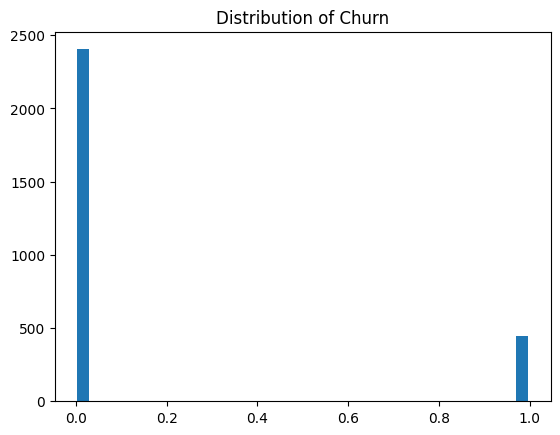

In [3]:
cols = df_clean.columns

for col in cols: 
    plt.figure()
    plt.hist(df_clean[col], bins=30, rwidth=0.8)
    plt.title(f"Distribution of {col}")
    plt.show()



Call Failure: 8 call failure on average, and some people experience (max) 36 fail call

Complain: 75% customer do not complain 

Subscription Length: On average 33 months (2.5 years) and long term customer up to 4 years 

Seconds of use: On average (4,472 seconds) 74.5 minutes, half is less than 54 mins, and some customer use it a lot more than the other (4.75 hours) 

Frequency of use: On average 70 times, half is less than 54 mins, with max of 255

Frequency of SMS: On average 74 SMS, half is less than 21 SMS, and very few has 522 SMS (highly skewed)

Distinct called number: On avg 24, half is less than 21, with few people have 97 distinct called numbers. 

Age group: there are 5 age group, most dense is in 2 and 3 (teen-adult)

Tariff Plan: On avg 1.08 (plan) with some people on plan 2

Status: On avg 1.25 (1 = active) and few is non active

Age: On avg 31 year, range of 15 - 55 (teen - middle age) 

Customer value: 0 - 2.165 possibly the amount of money deposited/bought in company, a lot of customer have 0/low value (most likely using free plan) and very few is way more valuable than others

Churn: 
15.7% churn rate (imbalanced towards non-churn meaning the model might biased against churn prediction) 





In [4]:
#Relationship between Complains and Churn

from scipy.stats import chi2_contingency

con_table = pd.crosstab(df_clean["Complains"], df_clean["Churn"])
chi2, p, dof, _ = chi2_contingency(con_table)
print(f"Chi Square of Complains and Churn: {chi2}")
print(f"P value: {p: .4f}")
    

Chi Square of Complains and Churn: 844.2918529832452
P value:  0.0000


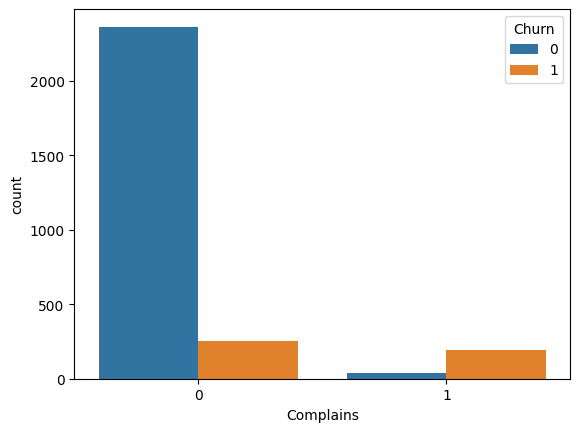

In [5]:
plt.figure()
sns.countplot(x="Complains", 
              hue="Churn", 
              data=df_clean) 
plt.show()

Chi2 test because we want to see the relationship between 2 categorical variables. Although churn and complains data type is both int64 as mentioned in the table above, but in reality 0 is not less than 1, its just an indicator that they dont churn / dont complain and vice versa

Chu2 test showed p value < 0.05 (very significant)

Very few complained. 
But those who complained will more likely to churn than not churn. 
There are more than 300 customer that churn although they didnt complain


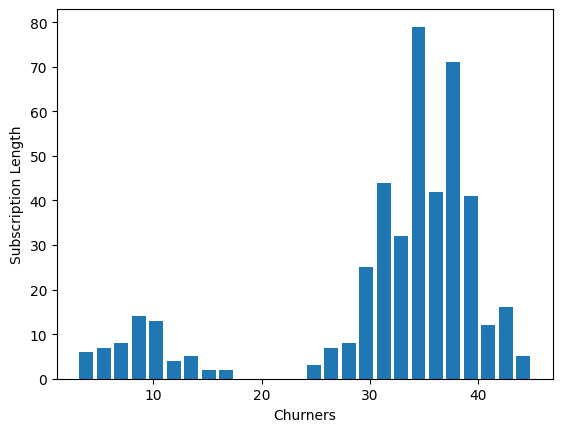

In [6]:
churn_sub = df_clean[df_clean["Churn"] == 1]["Subscription  Length"]
unchurn_sub = df_clean[df_clean["Churn"] == 0]["Subscription  Length"]

#Freedman Diaconis Rule to determine bins size
q75, q25 = np.percentile(churn_sub, [75, 25])
iqr = q75 - q25
bin_width = 2 * iqr / (churn_sub.shape[0] ** (1/3))
num_bins = int((max(churn_sub) - min(churn_sub)) / bin_width)

plt.figure()
plt.hist(
    churn_sub, 
    bins=num_bins, 
    rwidth=0.8
)
plt.xlabel("Churners")
plt.ylabel("Subscription Length")

plt.show()

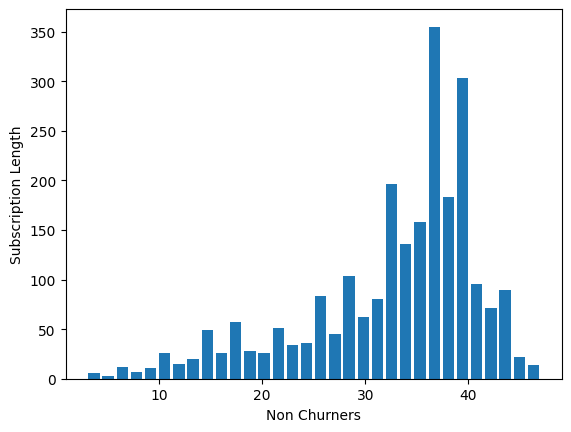

In [7]:
#Freedman Diaconis Rule
q75, q25 = np.percentile(unchurn_sub, [75, 25])
iqr = q75 - q25
bin_width = 2 * iqr / (unchurn_sub.shape[0] ** (1/3))
num_bins = int((max(unchurn_sub) - min(unchurn_sub)) / bin_width)

plt.figure()
plt.hist(
    unchurn_sub, 
    bins=num_bins, 
    rwidth=0.8
)
plt.xlabel("Non Churners")
plt.ylabel("Subscription Length")

plt.show()

We use freedman diaconis rules to determine bins because its better for skewed distribution. References: https://medium.com/@eddie.sotocastillo/the-art-of-histograms-finding-the-perfect-bin-size-for-data-visualization-b2264aa3f103

The graphs above shows that both have similar distribution, with both clusteers around 30 - 40. This shows that tenure/subs len is not enough for predicting churn 


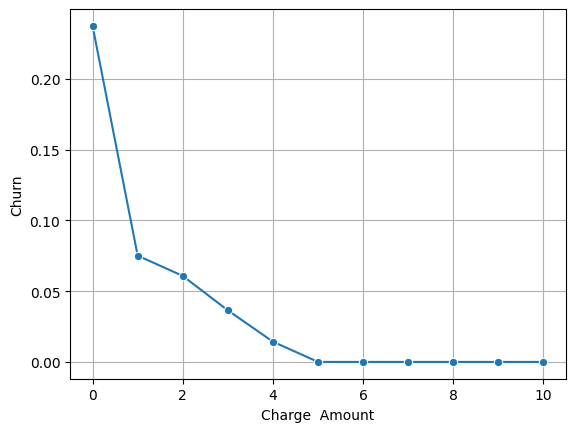

In [8]:
charge_churn = df_clean.groupby("Charge  Amount")["Churn"].mean().reset_index()

plt.figure()
sns.lineplot(x="Charge  Amount", 
             y="Churn", 
             data=charge_churn, 
             marker='o')
plt.grid(visible=True)
plt.show()

Free user (Charge amount 0 - 1) is more likely to churn. 

But customer who is charged, is more likely to stay. It could mean customer who stays recieve better services thus stayed longer. As the graph suggest, those that has charge amount of 4 and above have churn rate near to 0


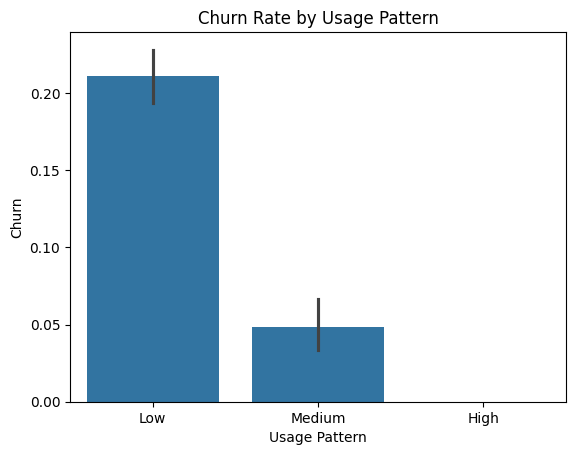

In [32]:
df_clean["Usage Level"] = pd.cut(df_clean["Frequency of use"], bins=3, labels=["Low", "Medium", "High"])

plt.figure()
sns.barplot(x="Usage Level",
            y="Churn", 
            data=df_clean)
plt.title("Churn Rate by Usage Pattern")
plt.xlabel("Usage Pattern")
plt.ylabel("Churn")
plt.show()

Customer with low usage has around >20% churn rate. Customer with medium usage has 5% churn rate, and high has almost 0. 

This shows that user with lower engagement tend to churn more, indicating poor onboarding/ initial offer. 

C:\Users\miche\AppData\Local\Temp\ipykernel_16268\3147568785.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Tariff Plan",


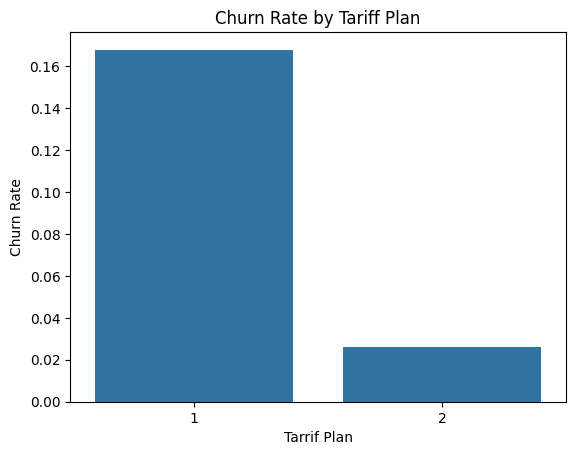

In [33]:
plt.figure()
sns.barplot(x="Tariff Plan", 
            y="Churn", 
            data=df_clean, 
            ci=None) 

plt.title("Churn Rate by Tariff Plan")
plt.xlabel("Tarrif Plan")
plt.ylabel("Churn Rate")
plt.show()

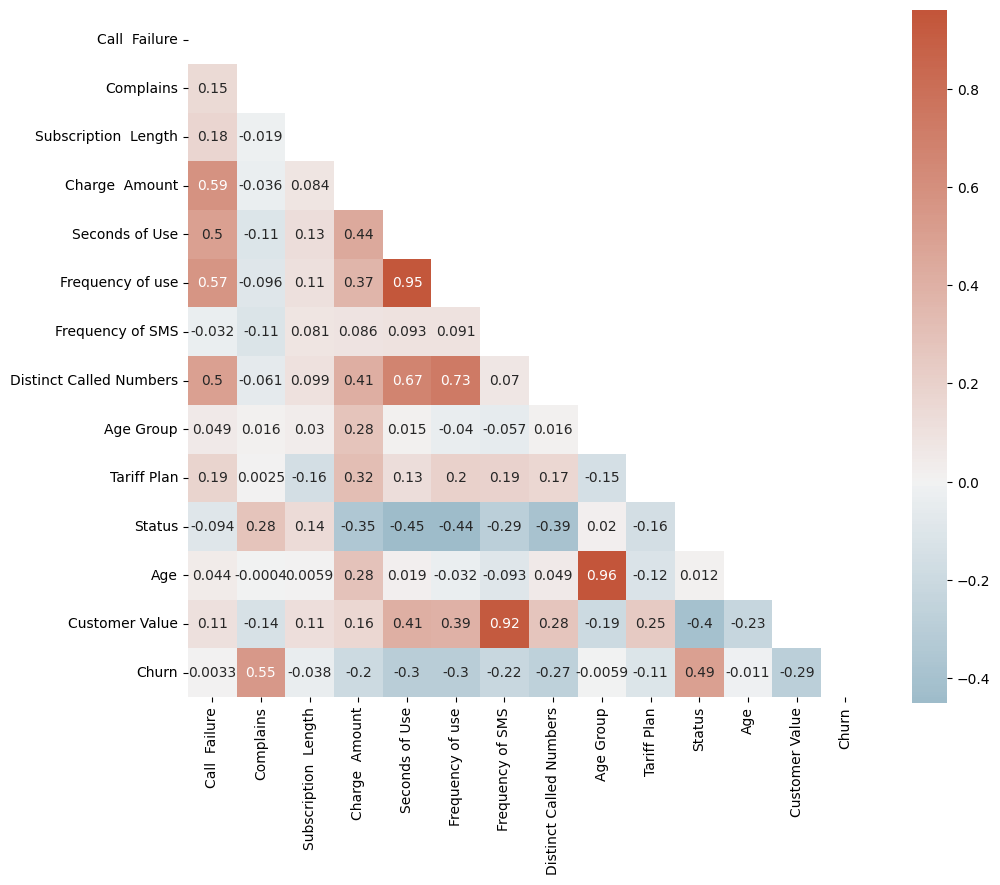

In [9]:
corr = df_clean.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 
                             20, 
                             as_cmap=True)
sns.heatmap(corr,  
            mask=mask, 
            cmap=cmap, 
            center=0, 
            square=True, 
            annot=True
            )

plt.show()
